# ADA final exam (winter semester 2019/2020)

A friend of yours wants to start a YouTube channel and ideally earn some money via ads. However, there are so many channels and videos out there that your friend has no idea where to even start. Fortunately, they know that you have taken ADA and think you might help them out by analyzing the videos that are currently on YouTube.

The data you are provided with is a subset of YouTube videos, with videos from some of the giant channels in two categories: "Gaming" and "How-to & Style", which are the categories your friend is choosing between. The dataset contains a lot of videos, with data on those videos including their titles, their total number of views in 2019, their tags and descriptions, etc. The data is, in gzip-compressed format, contained in the `data/` folder, as the file `youtube.csv.gz`.

The three tasks A, B and C are **independent** of each other, and you can solve any combination of them. The exam is designed for more than 3 hours, so don't worry if you don't manage to solve everything; you can still score a 6.

You need to run the following two cells to read and prepare the dataset.

In [1]:
import pandas as pd
import numpy as np

In [2]:
youtube = pd.read_csv('data/youtube.csv.gz', compression='gzip')
youtube.upload_date = pd.to_datetime(youtube.upload_date)

## Dataset description

Each row of the dataset corresponds to one video that was uploaded to YouTube. There are 11 columns:
'channel', 'upload_date', 'title', 'categories', 'tags', 'duration',
       'view_count', 'average_rating', 'height', 'width', 'channel_cat'.
- `channel`: The channel (account) on which the video was uploaded.
- `upload_date`: The date on which the video was uploaded (Pandas Timestamp object).
- `title`: The title of the video.
- `tags`: A list of words that describe the video.
- `duration`: The duration of the video in seconds.
- `view_count`: The number of times the video was watched.
- `average_rating`: The average score with which the viewers rated the video (1-5).
- `height`: The height of the video in pixels.
- `width`: The width of the video in pixels.
- `channel_cat`: The category of the channel on which this video was uploaded. This dataset only contains videos from channels from the 'Gaming' and the 'Howto & Style' category.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Task A: Welcome to the exam!

All of Task A refers to the videos that were published between and including 2010 and 2018.

## A1: A growing platform?

You would first like to know whether YouTube in general is the right platform to invest time into.

1. Using the appropriate plot type, plot the number of videos published per year between and including 2010 and 2018.

In [4]:
youtube.head()

,channel,upload_date,title,tags,duration,view_count,average_rating,height,width,channel_cat
0,PewDiePie,2013-03-04,A NEW ADVENTURE! - Kingdom Hearts (1) w/ Pewds,"['lets', 'play', 'horror', 'game', 'walkthroug...",1126.0,2541550.0,4.886102,720.0,1280.0,Gaming
1,PewDiePie,2013-03-04,SAVING PRIVATE PEWDS - Conker's Bad Fur Day (15),"['lets', 'play', 'horror', 'game', 'walkthroug...",903.0,1727646.0,4.951531,720.0,1280.0,Gaming
2,PewDiePie,2013-03-04,THE WORST SCARE! - Amnesia: Rain (4),"['lets', 'play', 'horror', 'game', 'walkthroug...",806.0,1402747.0,4.962706,720.0,1280.0,Gaming
3,PewDiePie,2013-03-03,Nova / Sp00n / Cry / Pewds - Worms Revolution ...,"['lets', 'play', 'horror', 'game', 'walkthroug...",909.0,4348296.0,4.937665,720.0,1280.0,Gaming
4,PewDiePie,2013-03-03,SEXIEST HORROR EVER - Amnesia: Rain (3),"['lets', 'play', 'horror', 'game', 'walkthroug...",834.0,1410659.0,4.957545,720.0,1280.0,Gaming


In [5]:
youtube.dtypes

channel                   object
upload_date       datetime64[ns]
title                     object
tags                      object
duration                 float64
view_count               float64
average_rating           float64
height                   float64
width                    float64
channel_cat               object
dtype: object

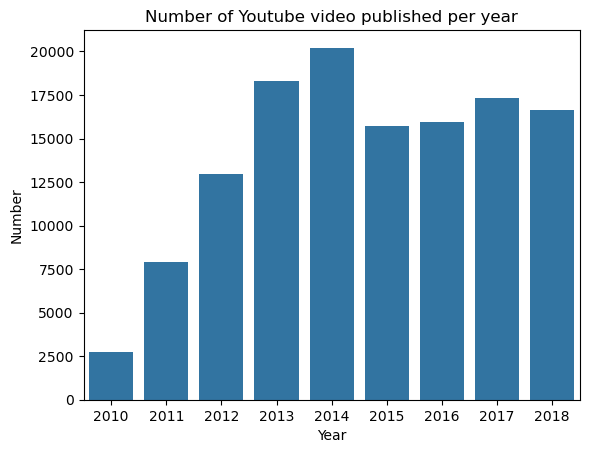

In [6]:
import seaborn as sns

youtube["upload_year"] = youtube.upload_date.dt.year
youtube["upload_month"] =  youtube.upload_date.dt.month

youtube_2010_2018 = youtube[(youtube.upload_year<=2018)&(youtube.upload_year>=2010)]
sns.barplot(youtube_2010_2018.groupby("upload_year").title.count())
plt.xlabel("Year")
plt.ylabel("Number")
plt.title("Number of Youtube video published per year")
plt.show()

2. Now for each year, plot the number of channels that have been created between the beginning of 2010 and the end of that year. A channel is considered to be created at the time at which they upload their first video.

In [7]:
old_channels = youtube[(youtube["upload_year"]<2010)].channel.unique()

youtube_2010_2018 = youtube_2010_2018[~(youtube_2010_2018.channel.isin(old_channels))]
youtube_2010_2018.channel.nunique()

164

In [8]:
youtube_2010_2018.sort_values(by="upload_year").drop_duplicates(subset="channel",keep="first").groupby("upload_year").channel.nunique().cumsum()

upload_year
2010     21
2011     47
2012     81
2013    102
2014    120
2015    133
2016    145
2017    162
2018    164
Name: channel, dtype: int64

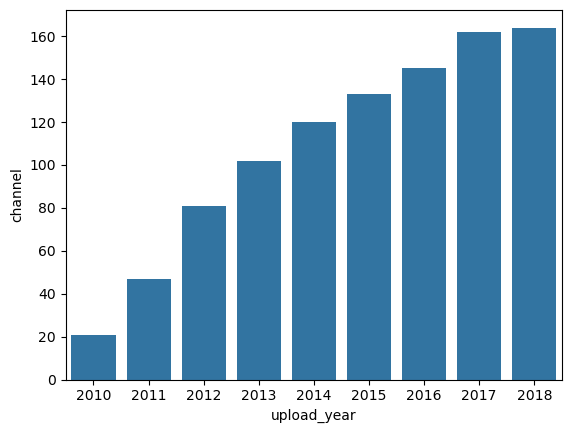

In [9]:
sns.barplot(youtube_2010_2018.sort_values(by="upload_year").drop_duplicates(subset="channel",keep="first").groupby("upload_year").channel.nunique().cumsum());

3. Normalize the number of videos published each year by the number of channels that have been created between the beginning of 2010 and the end of that year, and plot these quantities. Do seperate plots for gaming channels, how-to channels, and both together. Can you conclude from the plot that both gaming and how-to channels have been becoming less and less active recently? Why, or why not?

In [10]:
youtube_2010_2018.groupby("upload_year").title.count()

upload_year
2010      721
2011     5301
2012    10583
2013    15542
2014    17881
2015    13298
2016    13771
2017    16201
2018    15624
Name: title, dtype: int64

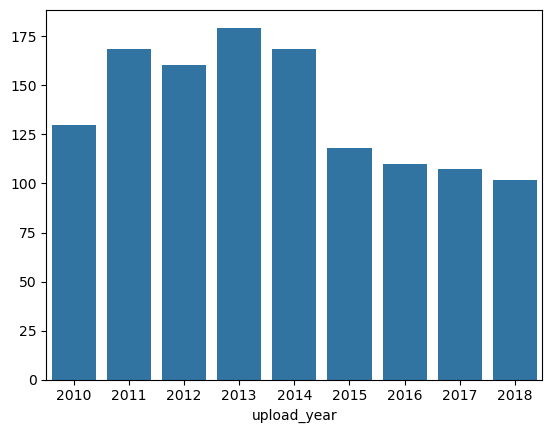

In [11]:
sns.barplot(youtube[(youtube["upload_year"]>=2010)&(youtube["upload_year"]<=2018)].groupby("upload_year").title.count()/(youtube_2010_2018.sort_values(by="upload_year").drop_duplicates(subset="channel",keep="first").groupby("upload_year").channel.nunique().cumsum()));

## A2: The one thing we all love: cash money

Your friend is really keen on making money from their YouTube channel through ads and wants you to help them choose the most profitable channel category (Gaming or Howto & Style). The ad profit is directly proportional to the number of views of a video.

1. Since your friend wants to keep producing videos for several years to come, it might also be worth looking at the growth of the two categories.
  1. Compute the total number of views in each category per year for the years 2010-2018.
  2. Divide the yearly view count by the number of channels that posted a video in each category in each year. Plot these normalized counts.




In [12]:
youtube.groupby("channel_cat").view_count.sum().reset_index()

,channel_cat,view_count
0,Gaming,1.359864e+11
1,Howto & Style,8.649324e+10


In [13]:
youtube_2010_2018[youtube_2010_2018["channel_cat"]=="Gaming"].groupby(["upload_year"]).channel.nunique()

upload_year
2010    14
2011    31
2012    49
2013    58
2014    62
2015    55
2016    53
2017    48
2018    43
Name: channel, dtype: int64

In [14]:
df = (youtube_2010_2018.groupby(["upload_year","channel_cat"]).view_count.sum()/youtube_2010_2018[youtube_2010_2018["channel_cat"]=="Gaming"].groupby(["upload_year"]).channel.nunique()).reset_index(name="ratio")
df

,upload_year,channel_cat,ratio
0,2010,Gaming,1.161353e+07
1,2010,Howto & Style,1.305253e+07
2,2011,Gaming,4.008120e+07
3,2011,Howto & Style,2.394771e+07
4,2012,Gaming,1.023349e+08
5,2012,Howto & Style,4.047342e+07
6,2013,Gaming,2.276278e+08
7,2013,Howto & Style,4.888634e+07
8,2014,Gaming,3.798700e+08
9,2014,Howto & Style,6.279382e+07


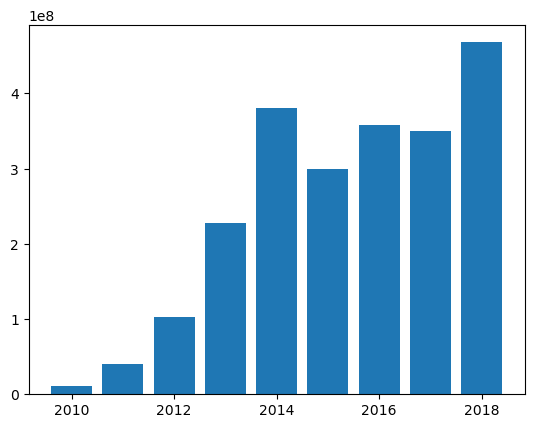

In [15]:
plt.bar(df[df["channel_cat"]=="Gaming"].upload_year, df[df["channel_cat"]=="Gaming"].ratio);

In [16]:
df = youtube.groupby("channel").nunique()

2. Your friend's channel will be brand new, so you decide to look more closely at newer channels. For this question and all the following questions in A2, only consider channels that uploaded their first video in  2016 or later. Compute the total number of views in each category and divide it by the number of channels in that category.


3. The number of views might be very unevenly over the different channels, and channels might upload different numbers of videos.
  1. Compute the mean number of views per video for each channel.
  2. Compute the mean of these means for each of the two categories. Print these values.
  3. Using bootstrapping, compute 95% confidence intervals for these two means. From this analysis, can you draw a recommendation for one of the two categories? Why, or why not?

In [17]:
channel_recent = youtube[['channel', 'upload_year']].groupby('channel').min().reset_index().query('upload_year>=2016').sort_values("upload_year")
channel_recent.channel.nunique()

31

In [18]:
youtube_o2016 = youtube[youtube["channel"].isin(channel_recent.channel)]
youtube_o2016.loc[youtube_o2016["channel_cat"]=="Gaming"].channel.nunique()

8

In [19]:
youtube_o2016.groupby("channel").view_count.mean()

channel
5-Minute Crafts            4.001437e+06
5-Minute Crafts GIRLY      1.810882e+06
5-Minute Crafts PLAY       1.879931e+06
Anaysa                     3.424131e+06
Antonio Garza              3.983921e+06
BRICO SYMPA                2.964726e+05
BRIGHT SIDE                3.602201e+06
Blossom                    1.143963e+07
Ceeday                     2.596953e+06
Chris Smoove               3.569548e+05
Clash Royale               2.037094e+06
Crafty Panda               1.509486e+07
Daequan Loco               1.136136e+06
Denis                      2.074953e+06
Frost Diamond              1.204915e+06
GameGrumps                 6.767778e+05
Grandpa Kitchen            2.774519e+06
Health Tips for You        7.638814e+04
Homemade solutions         3.291543e+06
Hong Giang DIY Slime       3.016172e+06
Indian Health              4.710675e+05
Izabela Stress             3.801210e+06
Jess No Limit              1.154385e+06
MeLlamanFredy              7.323903e+05
SHORT TIME SECRET          1.309

In [20]:
youtube_o2016.groupby("channel_cat").view_count.sum()/youtube_o2016.groupby("channel_cat").channel.nunique()

channel_cat
Gaming           8.954094e+08
Howto & Style    1.374135e+09
dtype: float64

In [21]:
howto_df = youtube_o2016.loc[youtube_o2016["channel_cat"]=="Howto & Style"].groupby("channel").view_count.mean().values
gaming_df = youtube_o2016.loc[youtube_o2016["channel_cat"]=="Gaming"].groupby("channel").view_count.mean().values

In [22]:
gaming_df

array([2596953.16492147,  356954.762     , 2037093.77150538,
       1136135.97790055, 2074953.125     , 1204915.41645885,
        676777.807     , 1154385.1088    ])

In [23]:
# Bootstraps
def bootstrap_function(df,n=1000):
    bootstrap_scores = []
    for i in range(n):
        # Extraction of the sample
        array = np.random.choice(df, size=len(df))
        bootstrap_scores.append(np.mean(array))
    return(np.percentile(bootstrap_scores, 2.5),np.percentile(bootstrap_scores, 97.5))

print(bootstrap_function(howto_df,1000))
print(bootstrap_function(gaming_df,1000))

(2071385.9595226746, 4871738.350998784)
(916168.7797403169, 1922549.569070473)


# Task B: View forecasting (Machine Learning)

Your friend wants to figure out how they can optimize their videos for getting the maximum number of views (without using shocking thumbnails and clickbait titles). In this task, you will build a machine learning (ML) model for predicting the success of a video.

## B1: Get those shovels out again

1. For the prediction model, use all rows of the dataset, but keep only the following columns: `view_count, channel, upload_date, duration, average_rating, height, width`.

In [24]:
youtube_B = youtube[["view_count","channel","upload_date","duration","average_rating","height","width"]].copy()

2. Extract the upload year and upload month from the `upload_date` column into the two columns `upload_year` and `upload_month`, and remove `upload_date`.

In [25]:
youtube_B["upload_year"] = youtube.upload_date.dt.year
youtube_B["upload_month"] = youtube.upload_date.dt.month
youtube_B = youtube_B.drop(columns="upload_date")

3. The entry in the channel column for a video indicates on which channel the video was uploaded. Encode this column via one-hot encoding.

In [26]:
from sklearn.preprocessing import OneHotEncoder

X = pd.get_dummies(youtube_B, columns=['channel'], prefix=["channel_"])

4. Split the data into a train (70%) and a test set (30%) with the appropriate function from sklearn, using 42 as the random seed.

In [27]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(X,test_size=0.3,random_state=42)

## B2: Who is the most viewed of them all?

1. Train a ridge regression model (i.e., an L2-regularized linear regression model) on the train set that predicts the view count from the other features. Find and use the optimal regularization parameter $\alpha$ from the set {0.001, 0.01, 0.1} via 3-fold cross validation.

In [28]:
X_train = train.drop(columns=["view_count"])
y_train = train["view_count"]
X_test = test.drop(columns=["view_count"])
y_test = test["view_count"]

In [29]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score, GridSearchCV

ridge = Ridge()
ridge_hyper = {'alpha':(0.001, 0.01, 0.1)}
ridge_cv = GridSearchCV(ridge, ridge_hyper, cv=3)
ridge_cv.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=Ridge(), param_grid={'alpha': (0.001, 0.01, 0.1)})

In [30]:
ridge_cv.cv_results_['mean_test_score']

array([0.08010146, 0.08010271, 0.0801151 ])

2. Report the mean absolute error that the model makes on the test set.

In [31]:
y_pred = ridge_cv.predict(X_test)
mean_absolute_error(y_test,y_pred)

1444649.5039951468

## B3: Checking our ambitions

To improve performance, you want to make the task of the ML model easier and turn it into a classification task. Now it only has to predict whether a video has a high view count (defined as being larger than the median of the view counts in the training set) or a low view count (defined as being smaller or equal to the median of the view counts in the training set).

1. Train a logistic regression model for this classification task. Find and use the optimal regularization parameter C (as defined in scikit-learn's documentation) from the set {1, 10, 100} via 3-fold cross validation. Use the random seed 42. _Hint_: If you get a warning about the training algorithm failing to converge, increase the maximum number of training iterations.

In [32]:
from sklearn.linear_model import LogisticRegressionCV

Cs = (1, 10, 100)
log_reg_cv = LogisticRegressionCV(Cs=Cs, cv=3, random_state=42, max_iter=200)

In [33]:
threshold = y_train.median()

y_train_2 = (y_train>threshold).astype(int).values
y_test_2 = (y_test>threshold).astype(int).values

In [34]:
log_reg_cv.fit(X_train,y_train_2)

LogisticRegressionCV(Cs=(1, 10, 100), cv=3, max_iter=200, random_state=42)

In [35]:
log_reg_cv.C_[0]

1

In [36]:
log_reg_cv.scores_[1].mean(axis=0)

array([0.74790585, 0.74790585, 0.74790585])

2. Compute the accuracy of the logistic regression model on the test set.

In [37]:
log_reg_cv.score(X_test,y_test_2)

0.7479272692519054

## B4: ...something's not right.

You are satisfied with the model performance. In fact, you are a bit surprised at how good the model is given the relatively little amount of information about the videos. So you take a closer look at the features and realize that the (one-hot-encoded) channel feature does not make sense for the application that your friend has in mind.

1. Why does the channel feature not make sense?

In [38]:
#predict for existing channels, not his future channel

2. Train another logistic regression model with all the features from B3 except the one-hot-encoded channel. Use again 42 as the seed for the train test split and perform the same hyperparameter optimization as in B3. How does the model performance change?

In [39]:
X_train_B4 = train[["duration","average_rating","height","width","upload_year","upload_month"]]
y_train_B4 = train["view_count"]
X_test_B4 = test[["duration","average_rating","height","width","upload_year","upload_month"]]
y_test_B4 = test["view_count"]

In [40]:
threshold = y_train_B4.median()

y_train_B4 = (y_train_B4>threshold).astype(int).values
y_test_B4 = (y_test_B4>threshold).astype(int).values

log_reg_cv.fit(X_train_B4,y_train_B4)

LogisticRegressionCV(Cs=(1, 10, 100), cv=3, max_iter=200, random_state=42)

In [41]:
log_reg_cv.C_[0]

100

In [42]:
log_reg_cv.scores_[1].mean(axis=0)

array([0.60827001, 0.6107481 , 0.6107993 ])

In [43]:
log_reg_cv.score(X_test_B4,y_test_B4)

0.6075311208276587

## B5: "We kinda forgot about categories."

On second thought, there is actually one feature that you may use about the channel. Namely, the channel category. The reason this one makes sense might also help you answer B4.1.

1. Train and evaluate another logistic regression model (in the same way as in B4 regarding train/test split and hyperparameter) that additionally includes the one-hot-encoded channel category.

2. The dynamics of the two categories might differ a lot, and the two communities might value different properties of a video differently. For instance, for one community, a long duration might be more important, for the other one, a large picture width. Thus, having only a single weight for, e.g., the duration of a video, might not give the best results. Is there something smarter that you can do than simply including the category as a single one-hot-encoded feature to improve the classification performance? Implement your idea and compare the accuracy on the test set with that of the first model (from task B5.1).

# Task C: A map of the channels (Graphs)

Your friend wants to map out the channels and represent their similarities. For this purpose, we have created two undirected and unweighted graphs for you, where in each graph, each channel has a node and similar channels have edges connecting them. In one graph, the similarity between two channels is based on how similar their video descriptions are, while in the other, the similarity is based on how similar their video tags are. We will call the former $G_{text}$ and the latter $G_{tags}$. You will be analyzing the two graphs loaded by running the cell below.

In [44]:
from networkx import from_numpy_array
import json
g_text_adj = np.loadtxt(open('data/g_text_adj.csv', 'r'), delimiter=',', skiprows=0)
g_tags_adj = np.loadtxt(open('data/g_tags_adj.csv', 'r'), delimiter=',', skiprows=0)
channel_to_index = json.load(open('data/channel_indices.json', 'r'))
g_text = from_numpy_array(g_text_adj)
g_tags = from_numpy_array(g_tags_adj)

## C1: Does YouTube have a content diversity problem?

1. For each graph, calculate its diameter (i.e., the largest shortest-path length, where the maximization is done over all node pairs). What difference do you see? _Hint_: Don't worry if you get an error, just read the error message carefully.

In [50]:
import networkx as nx

print(nx.diameter(g_text))
print(nx.diameter(g_tags))

2


NetworkXError: Found infinite path length because the graph is not connected

2. What does the diameter of $G_{text}$ say about the diversity of the channels’ contents? How about the diameter of $G_{tags}$?

In [52]:
print(nx.number_connected_components(g_text))
print(nx.number_connected_components(g_tags))

1
2


3. Based on what you have calculated, which one has greater diversity: descriptions used by channels, or tags used by channels? Justify your answer.

4. Imagine that you want to **compare** content diversity between two sets of channels (i.e., you want to see which set of channels has more diverse content), and you have calculated a tag-based graph for each set. Do you think the diameter is a good measure for doing the comparison? Justify your answer.

In [ ]:
#mean and not std

5. Back to our own two graphs. Based on $G_{text}$, for each category of channels, which channel is the one most representative of the contents of all channels in that category? In other words, for each category, if you needed to provide a summary of all channels in the category via one channel, which channel would you choose? Show us (us being the exam designers and your friend) the descriptions of this channel’s two most-viewed videos. What metric did you use for this purpose? Explain your choice.

In [59]:
btw_centr = nx.betweenness_centrality(g_text)

high = sorted(btw_centr.keys(), key=lambda x: btw_centr[x], reverse=True)[0]
high

1

In [70]:
chan = {v:k for k,v in channel_to_index.items()}[high]
chan

'Desi Perkins'

In [75]:
youtube.loc[youtube["channel"]==chan].sort_values("view_count", ascending=False).head(2)

,channel,upload_date,title,tags,duration,view_count,average_rating,height,width,channel_cat,upload_year,upload_month
137477,Desi Perkins,2014-05-04,EYEBROW TUTORIAL,"['how to', 'makeup', 'tutorial']",528.0,16851339.0,4.922917,1080.0,1920.0,Howto & Style,2014,5
137267,Desi Perkins,2017-08-16,KIM KARDASHIAN WEST MAKEUP TUTORIAL + NEW KKW ...,[],1499.0,8925152.0,4.888759,1080.0,1920.0,Howto & Style,2017,8


## C2: Going back to categories again

1. We want to use the two graphs to cluster channels from the same category together, and we want to compare their effectiveness at doing so. Use Kernighan-Lin bisection in the networkx package (`networkx.algorithms.community.kernighan_lin_bisection`) to divide each graph into two communities. Use 42 as the random seed. For each graph, show how many members of each category fall into each of the two communities.

In [36]:
from networkx.algorithms import community

community.kernighan_lin_bisection(g_text)

({1,
  2,
  3,
  4,
  8,
  9,
  10,
  11,
  13,
  14,
  16,
  17,
  18,
  25,
  31,
  33,
  34,
  35,
  36,
  37,
  40,
  42,
  43,
  44,
  49,
  51,
  54,
  55,
  56,
  63,
  67,
  69,
  71,
  73,
  74,
  76,
  77,
  82,
  83,
  84,
  86,
  88,
  90,
  91,
  94,
  98,
  100,
  104,
  105,
  106,
  111,
  112,
  113,
  115,
  116,
  117,
  118,
  120,
  121,
  122,
  123,
  126,
  127,
  132,
  135,
  137,
  138,
  139,
  143,
  144,
  146,
  147,
  148,
  149,
  151,
  152,
  153,
  154,
  155,
  158,
  160,
  161,
  162,
  165,
  167,
  172,
  173,
  176,
  178,
  179,
  182,
  184,
  186,
  188,
  191,
  192,
  193},
 {0,
  5,
  6,
  7,
  12,
  15,
  19,
  20,
  21,
  22,
  23,
  24,
  26,
  27,
  28,
  29,
  30,
  32,
  38,
  39,
  41,
  45,
  46,
  47,
  48,
  50,
  52,
  53,
  57,
  58,
  59,
  60,
  61,
  62,
  64,
  65,
  66,
  68,
  70,
  72,
  75,
  78,
  79,
  80,
  81,
  85,
  87,
  89,
  92,
  93,
  95,
  96,
  97,
  99,
  101,
  102,
  103,
  107,
  108,
  109,
  110,
  1

2. If one of these graphs were ideal for this clustering task, what would the resulting communities look like? If it were the absolute worst possible graph for the task, what would the resulting communities look like?

3. Calculate the probability $P(community|category)$ for each community and category within each graph. Design a metric, using the four $P(community|category)$ values in a graph, whose value would be 1 for the ideal graph and 0 for the worst graph. Calculate this metric for both graphs and compare the two. What do the results say about how representative tags and descriptions are regarding the channel categories? Are tags better suited, or descriptions?

4. The Kernighan-Lin bisection you used above performs a min-edge cut: It attempts to partition the nodes of the graph into two sets of almost-equal size by deleting as few edges as possible. It starts off by creating a random partition of the nodes of the graph into two sets A and B that are almost equal in size, and then iteratively and in a greedy fashion moves nodes between A and B to reduce the number of edges between A and B. Show at least one toy example of a graph where the initialization could also be the final result. (Hint: Think of how, as we explained, the bisection algorithm relies on a minimum edge cut with a random initialization; under what circumstances could the original A and B be the best partition given that graph?)